# MNIST Generator

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchmetrics.image.fid import FrechetInceptionDistance

In [2]:
import sys
sys.path.append("./models")

In [3]:
batch_size=64

digit = 8  #classe choisie
transform = transforms.Compose([transforms.ToTensor()])

mnist_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
indices = [i for i, label in enumerate(mnist_full.targets) if label == digit]
mnist_digit = torch.utils.data.Subset(mnist_full, indices)

train_loader = torch.utils.data.DataLoader(mnist_digit, batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:02<00:00, 3.33MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 291kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [4]:
print("Nombre d'images dans les données choisies :",len(indices))

Nombre d'images dans les données choisies : 5851


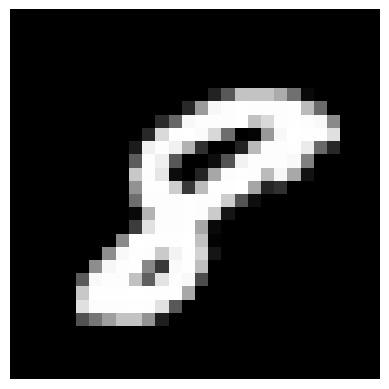

In [5]:
img, label = mnist_digit[80]
plt.imshow(img.squeeze(), cmap="gray")
plt.axis('off')
plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Generation Function

In [30]:
def generate_image(model, steps=100, device="cuda"):

    x_t = torch.randn(1, 1, 28, 28, device=device)

    dt = 1.0 / steps

    for step in range(steps):
        t = torch.tensor([[step*dt]], device=device) # Time
        v = model(x_t, t) # Predicted vector field
        x_t = x_t + dt * v  # "Next" image

    x_gen = torch.clip(x_t, 0.0, 1.0)
    return x_gen


### Basic CNN

In [8]:
import CNN1 as CNN1
model = CNN1.CNN1()


In [9]:
n_epochs = 10000

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=50)
model = model.to(device)

for epoch in range(n_epochs):

    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).to(torch.float32)

    x_0 = torch.randn_like(x_1).to(device)

    t = torch.rand(batch_size, 1).to(device)

    x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1

    v_true = x_1 - x_0

    v_pred = model(x_t, t)

    loss = ((v_pred - v_true) ** 2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch} | loss = {loss.item():.4f}")

epoch 0 | loss = 1.1342
epoch 100 | loss = 0.4553
epoch 200 | loss = 0.3907
epoch 300 | loss = 0.3141
epoch 400 | loss = 0.3000
epoch 500 | loss = 0.2693
epoch 600 | loss = 0.2569
epoch 700 | loss = 0.2170
epoch 800 | loss = 0.2184
epoch 900 | loss = 0.2387
epoch 1000 | loss = 0.2212
epoch 1100 | loss = 0.2107
epoch 1200 | loss = 0.1871
epoch 1300 | loss = 0.1865
epoch 1400 | loss = 0.2061
epoch 1500 | loss = 0.1924
epoch 1600 | loss = 0.1979
epoch 1700 | loss = 0.1588
epoch 1800 | loss = 0.1859
epoch 1900 | loss = 0.1866
epoch 2000 | loss = 0.1537
epoch 2100 | loss = 0.1622
epoch 2200 | loss = 0.1911
epoch 2300 | loss = 0.1792
epoch 2400 | loss = 0.1650
epoch 2500 | loss = 0.2013
epoch 2600 | loss = 0.1865
epoch 2700 | loss = 0.1953
epoch 2800 | loss = 0.1838
epoch 2900 | loss = 0.1701
epoch 3000 | loss = 0.1978
epoch 3100 | loss = 0.1626
epoch 3200 | loss = 0.1704
epoch 3300 | loss = 0.1686
epoch 3400 | loss = 0.1820
epoch 3500 | loss = 0.1691
epoch 3600 | loss = 0.1554
epoch 3700 | 

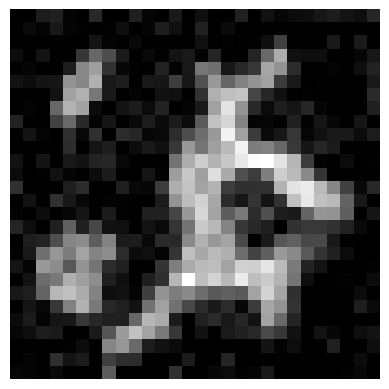

In [10]:
model = model.to(device)
x_gen = generate_image(model)
import matplotlib.pyplot as plt
plt.imshow(x_gen[0,0].cpu().detach(), cmap="gray")
plt.axis("off")
plt.show()

Does not look like a number, but we see the model generated white shape on black background. Good start.

Number of parameters

In [28]:
print(sum(p.numel() for p in model.parameters()))

56609


### Basic UNET

In [12]:
import UNET as UNET


model2 = UNET.UNet4()

In [13]:
n_epochs = 5000
model2 = model2.to(device)

optim = torch.optim.Adam(model2.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=50)


for epoch in range(n_epochs):

    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).to(torch.float32)

    x_0 = torch.randn_like(x_1).to(device)

    t = torch.rand(batch_size, 1).to(device)

    x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1

    v_true = x_1 - x_0

    v_pred = model2(x_t, t)

    loss = ((v_pred - v_true) ** 2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 200 == 0:
        print(f"epoch {epoch} | loss = {loss.item():.4f}")

epoch 0 | loss = 1.1132
epoch 200 | loss = 0.3636
epoch 400 | loss = 0.2583
epoch 600 | loss = 0.2510
epoch 800 | loss = 0.2715
epoch 1000 | loss = 0.2014
epoch 1200 | loss = 0.1735
epoch 1400 | loss = 0.1672
epoch 1600 | loss = 0.1652
epoch 1800 | loss = 0.1872
epoch 2000 | loss = 0.1705
epoch 2200 | loss = 0.1408
epoch 2400 | loss = 0.1507
epoch 2600 | loss = 0.1394
epoch 2800 | loss = 0.1355
epoch 3000 | loss = 0.1361
epoch 3200 | loss = 0.1292
epoch 3400 | loss = 0.1301
epoch 3600 | loss = 0.1623
epoch 3800 | loss = 0.1409
epoch 4000 | loss = 0.1430
epoch 4200 | loss = 0.1478
epoch 4400 | loss = 0.1357
epoch 4600 | loss = 0.1688
epoch 4800 | loss = 0.1209


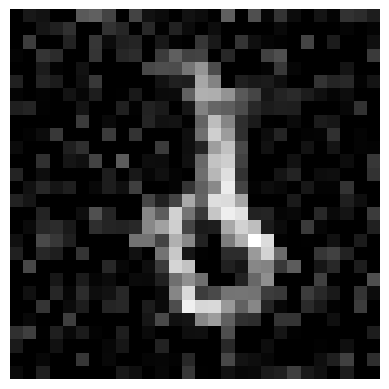

In [14]:
x_gen = generate_image(model2)
import matplotlib.pyplot as plt
plt.imshow(x_gen[0,0].cpu().detach(), cmap="gray")
plt.axis("off")
plt.show()

Still not a number, but the white mass is no longer scattered in several spots but is well grouped together.

In [27]:
print(sum(p.numel() for p in model2.parameters()))

903169


# UNet ChatGPT (previous UNet with residual blocks added using an LLM)

In [16]:
import UNET_ChatGPT as UNET2


model3 = UNET2.UNetEnhanced()

In [17]:
n_epochs = 2000
model3 = model3.to(device)

optim = torch.optim.Adam(model3.parameters(), lr=0.001)

for epoch in range(n_epochs):

    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).to(torch.float32)

    x_0 = torch.randn_like(x_1).to(device)

    t = torch.rand(batch_size, 1).to(device)

    x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1

    v_true = x_1 - x_0

    v_pred = model3(x_t, t)

    loss = ((v_pred - v_true) ** 2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch} | loss = {loss.item():.4f}")

epoch 0 | loss = 1.2822
epoch 100 | loss = 0.1395
epoch 200 | loss = 0.1266
epoch 300 | loss = 0.1503
epoch 400 | loss = 0.1165
epoch 500 | loss = 0.1071
epoch 600 | loss = 0.1118
epoch 700 | loss = 0.1068
epoch 800 | loss = 0.1193
epoch 900 | loss = 0.1076
epoch 1000 | loss = 0.1113
epoch 1100 | loss = 0.1119
epoch 1200 | loss = 0.0999
epoch 1300 | loss = 0.0937
epoch 1400 | loss = 0.1311
epoch 1500 | loss = 0.1010
epoch 1600 | loss = 0.1052
epoch 1700 | loss = 0.1066
epoch 1800 | loss = 0.1063
epoch 1900 | loss = 0.0974


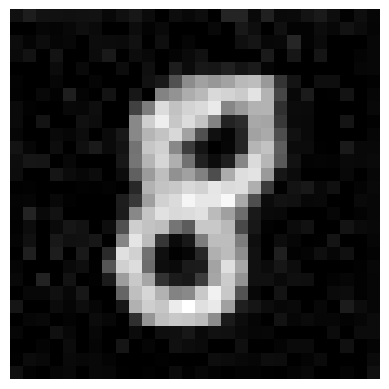

In [26]:
x_gen = generate_image(model3)
import matplotlib.pyplot as plt
plt.imshow(x_gen[0,0].cpu().detach(), cmap="gray")
plt.axis("off")
plt.show()

We can fully recognize an 8, but there is noise around the number (the background is not fully black)

In [19]:
print(sum(p.numel() for p in model3.parameters()))

7778049


### Unet OPENAI

In [20]:
import unet_OPENAI as UNET_OAI

model4 = UNET_OAI.UNetModel(
    image_size=28,
    in_channels=1,                # 1 Canal
    model_channels=96,           # N_filtres
    out_channels=1,               
    num_res_blocks=2,             # Nombre de blocs résiduels
    attention_resolutions=[8],   # attention à 8x8
    channel_mult=[1, 2],        # profondeur du UNet et multiplicateur de filtres
    dropout=0.1,                  
    use_checkpoint=True,         
)

In [29]:
from nn import timestep_embedding

n_epochs = 1000
model4 = model4.to(device)
optim = torch.optim.Adam(model4.parameters(), 0.001)

for epoch in range(n_epochs):

    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).float()

    x_0 = torch.randn_like(x_1)

    B = x_1.size(0)
    t = torch.rand(B, device=device)
    x_t = (1 - t.view(B,1,1,1)) * x_0 + t.view(B,1,1,1) * x_1


    v_true = x_1 - x_0

    v_pred = model4(x_t, t * 1000) # Major difference : time is now an embedding

    loss = ((v_pred - v_true) ** 2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if(epoch%50 == 0):
        print(f"[epoch {epoch}] loss = {loss.item():.4f}")


[epoch 0] loss = 0.1055


KeyboardInterrupt: 

We need a new function to generate images because time is managed differently with this UNet

In [22]:
import torch

def generate_image2(model, steps=100, device="cuda"):

    x_t = torch.randn(1, 1, 28, 28, device=device)
    dt = 1.0 / steps

    for step in range(steps):
        t_float = step * dt
        # convertir en entier pour l'embedding timestep
        if step == 0:
            print(t_float)
        t_int = torch.tensor([int(t_float * 1000)], device=device)
        v = model(x_t, t_int)
        x_t = x_t + dt * v

    x_gen = torch.clamp(x_t, 0.0, 1.0)
    img = x_gen[0].permute(1, 2, 0).cpu().detach().numpy()

    return x_gen




0.0


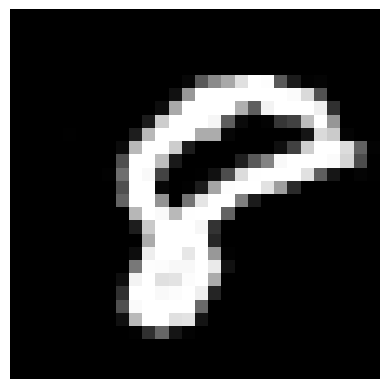

In [23]:
x_gen_OAI = generate_image2(model4)
import matplotlib.pyplot as plt
plt.imshow(x_gen_OAI[0,0].cpu().detach(), cmap="gray")
plt.axis("off")
plt.show()

We can still recognize an 8, but this time there is no noise around the number (blacl background)

In [24]:
print(sum(p.numel() for p in model4.parameters()))

8221825
